```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Optimal Growth III: Time Iteration <single: Optimal Growth III: Time Iteration>`

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon
!pip install interpolation

## Overview

In this lecture, we'll continue our {doc}`earlier <optgrowth>` study of the stochastic optimal growth model.

In that lecture, we solved the associated dynamic programming
problem using value function iteration.

The beauty of this technique is its broad applicability.

With numerical problems, however, we can often attain higher efficiency in
specific applications by deriving methods that are carefully tailored to the
application at hand.

The stochastic optimal growth model has plenty of structure to exploit for
this purpose, especially when we adopt some concavity and smoothness
assumptions over primitives.

We'll use this structure to obtain an Euler equation based method.

This will be an extension of the time iteration method considered
in our elementary lecture on {doc}`cake eating <cake_eating_numerical>`.

In a {doc}`subsequent lecture <egm_policy_iter>`, we'll see that time
iteration can be further adjusted to obtain even more efficiency.

Let's start with some imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit

/opt/conda/envs/quantecon/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## The Euler Equation

Our first step is to derive the Euler equation, which is a generalization of
the Euler equation we obtained in the {doc}`lecture on cake eating <cake_eating_problem>`.

We take the model set out in {doc}`the stochastic growth model lecture <optgrowth>` and add the following assumptions:

1. $u$ and $f$ are continuously differentiable and strictly concave
1. $f(0) = 0$
1. $\lim_{c \to 0} u'(c) = \infty$ and $\lim_{c \to \infty} u'(c) = 0$
1. $\lim_{k \to 0} f'(k) = \infty$ and $\lim_{k \to \infty} f'(k) = 0$

The last two conditions are usually called **Inada conditions**.

Recall the Bellman equation

```{math}
:label: cpi_fpb30

v^*(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
    \right\}
\quad \text{for all} \quad
y \in \mathbb R_+
```

Let the optimal consumption policy be denoted by $\sigma^*$.

We know that $\sigma^*$ is a $v^*$-greedy policy so that $\sigma^*(y)$ is the maximizer in {eq}`cpi_fpb30`.

The conditions above imply that

* $\sigma^*$ is the unique optimal policy for the stochastic optimal growth model
* the optimal policy is continuous, strictly increasing and also **interior**, in the sense that $0 < \sigma^*(y) < y$ for all strictly positive $y$, and
* the value function is strictly concave and continuously differentiable, with

```{math}
:label: cpi_env

(v^*)'(y) = u' (\sigma^*(y) ) := (u' \circ \sigma^*)(y)
```

The last result is called the **envelope condition** due to its relationship with the [envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem).

To see why {eq}`cpi_env` holds, write the Bellman equation in the equivalent
form

$$
v^*(y) = \max_{0 \leq k \leq y}
    \left\{
        u(y-k) + \beta \int v^*(f(k) z) \phi(dz)
    \right\},
$$

Differentiating with respect to $y$,  and then evaluating at the optimum yields {eq}`cpi_env`.

(Section 12.1 of [EDTC](https://johnstachurski.net/edtc.html) contains full proofs of these results, and closely related discussions can be found in many other texts.)

Differentiability of the value function and interiority of the optimal policy
imply that optimal consumption satisfies the first order condition associated
with {eq}`cpi_fpb30`, which is

```{math}
:label: cpi_foc

u'(\sigma^*(y)) = \beta \int (v^*)'(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z \phi(dz)
```

Combining {eq}`cpi_env` and the first-order condition {eq}`cpi_foc` gives the **Euler equation**

```{math}
:label: cpi_euler

(u'\circ \sigma^*)(y)
= \beta \int (u'\circ \sigma^*)(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z \phi(dz)
```

We can think of the Euler equation as a functional equation

```{math}
:label: cpi_euler_func

(u'\circ \sigma)(y)
= \beta \int (u'\circ \sigma)(f(y - \sigma(y)) z) f'(y - \sigma(y)) z \phi(dz)
```

over interior consumption policies $\sigma$, one solution of which is the optimal policy $\sigma^*$.

Our aim is to solve the functional equation {eq}`cpi_euler_func` and hence obtain $\sigma^*$.

### The Coleman-Reffett Operator

Recall the Bellman operator

```{math}
:label: fcbell20_coleman

Tv(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
\right\}
```

Just as we introduced the Bellman operator to solve the Bellman equation, we
will now introduce an operator over policies to help us solve the Euler
equation.

This operator $K$ will act on the set of all $\sigma \in \Sigma$
that are continuous, strictly increasing and interior.

Henceforth we denote this set of policies by $\mathscr P$

1. The operator $K$ takes as its argument a $\sigma \in \mathscr P$ and
1. returns a new function $K\sigma$,  where $K\sigma(y)$ is the $c \in (0, y)$ that solves.

```{math}
:label: cpi_coledef

u'(c)
= \beta \int (u' \circ \sigma) (f(y - c) z ) f'(y - c) z \phi(dz)
```

We call this operator the **Coleman-Reffett operator** to acknowledge the work of
{cite}`Coleman1990` and {cite}`Reffett1996`.

In essence, $K\sigma$ is the consumption policy that the Euler equation tells
you to choose today when your future consumption policy is $\sigma$.

The  important thing to note about $K$ is that, by
construction, its fixed points coincide with solutions to the functional
equation {eq}`cpi_euler_func`.

In particular, the optimal policy $\sigma^*$ is a fixed point.

Indeed, for fixed $y$, the value $K\sigma^*(y)$ is the $c$ that
solves

$$
u'(c)
= \beta \int (u' \circ \sigma^*) (f(y - c) z ) f'(y - c) z \phi(dz)
$$

In view of the Euler equation, this is exactly $\sigma^*(y)$.

### Is the Coleman-Reffett Operator Well Defined?

In particular, is there always a unique $c \in (0, y)$ that solves
{eq}`cpi_coledef`?

The answer is yes, under our assumptions.

For any $\sigma \in \mathscr P$, the right side of {eq}`cpi_coledef`

* is continuous and strictly increasing in $c$ on $(0, y)$
* diverges to $+\infty$ as $c \uparrow y$

The left side of {eq}`cpi_coledef`

* is continuous and strictly decreasing in $c$ on $(0, y)$
* diverges to $+\infty$ as $c \downarrow 0$

Sketching these curves and using the information above will convince you that they cross exactly once as $c$ ranges over $(0, y)$.

With a bit more analysis, one can show in addition that $K \sigma \in \mathscr P$
whenever $\sigma \in \mathscr P$.

### Comparison with VFI (Theory)

It is possible to prove that there is a tight relationship between iterates of
$K$ and iterates of the Bellman operator.

Mathematically, the two operators are *topologically conjugate*.

Loosely speaking, this means that if iterates of one operator converge then
so do iterates of the other, and vice versa.

Moreover, there is a sense in which they converge at the same rate, at least
in theory.

However, it turns out that the operator $K$ is more stable numerically
and hence more efficient in the applications we consider.

Examples are given below.

## Implementation

As in our {doc}`previous study <optgrowth_fast>`, we continue to assume that

* $u(c) = \ln c$
* $f(k) = k^{\alpha}$
* $\phi$ is the distribution of $\xi := \exp(\mu + s \zeta)$ when $\zeta$ is standard normal

This will allow us to compare our results to the analytical solutions

In [3]:

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y



As discussed above, our plan is to solve the model using time iteration, which
means iterating with the operator $K$.

For this we need access to the functions $u'$ and $f, f'$.

These are available in a class called `OptimalGrowthModel` that we
constructed in an {doc}`earlier lecture <optgrowth_fast>`.

In [4]:
from numba import float64
from numba.experimental import jitclass

opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                α=0.4,
                β=0.96,
                μ=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))


    def f(self, k):
        "The production function"
        return k**self.α


    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return 1/c

    def u_prime_inv(self, c):
        "Inverse of u'"
        return 1/c


Now we implement a method called `euler_diff`, which returns

```{math}
:label: euler_diff

u'(c) - \beta \int (u' \circ \sigma) (f(y - c) z ) f'(y - c) z \phi(dz)
```

In [5]:
@njit
def euler_diff(c, σ, y, og):
    """
    Set up a function such that the root with respect to c,
    given y and σ, is equal to Kσ(y).

    """

    β, shocks, grid = og.β, og.shocks, og.grid
    f, f_prime, u_prime = og.f, og.f_prime, og.u_prime

    # First turn σ into a function via interpolation
    σ_func = lambda x: interp(grid, σ, x)

    # Now set up the function we need to find the root of.
    vals = u_prime(σ_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
    return u_prime(c) - β * np.mean(vals)

The function `euler_diff` evaluates integrals by Monte Carlo and
approximates functions using linear interpolation.

We will use a root-finding algorithm to solve {eq}`euler_diff` for $c$ given
state $y$ and $σ$, the current guess of the policy.

Here's the operator $K$, that implements the root-finding step.

In [6]:
@njit
def K(σ, og):
    """
    The Coleman-Reffett operator

     Here og is an instance of OptimalGrowthModel.
    """

    β = og.β
    f, f_prime, u_prime = og.f, og.f_prime, og.u_prime
    grid, shocks = og.grid, og.shocks

    σ_new = np.empty_like(σ)
    for i, y in enumerate(grid):
        # Solve for optimal c at y
        c_star = brentq(euler_diff, 1e-10, y-1e-10, args=(σ, y, og))[0]
        σ_new[i] = c_star

    return σ_new

### Testing

Let's generate an instance and plot some iterates of $K$, starting from $σ(y) = y$.

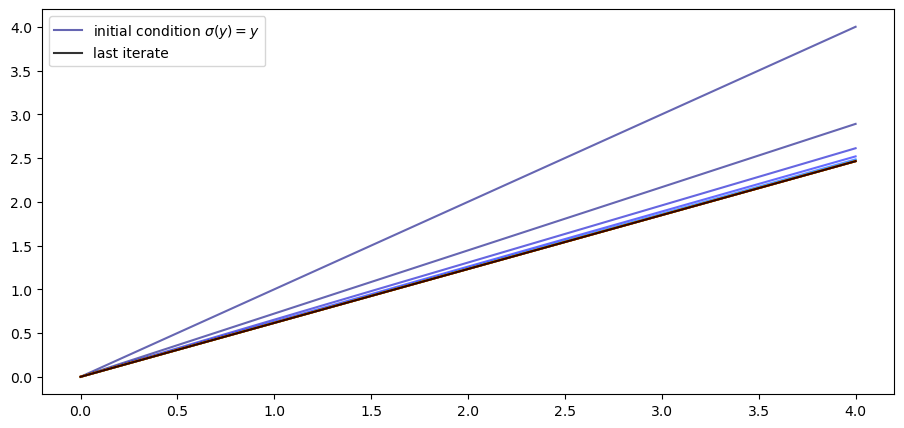

In [7]:
og = OptimalGrowthModel()
grid = og.grid

n = 15
σ = grid.copy()  # Set initial condition

fig, ax = plt.subplots()
lb = 'initial condition $\sigma(y) = y$'
ax.plot(grid, σ, color=plt.cm.jet(0), alpha=0.6, label=lb)

for i in range(n):
    σ = K(σ, og)
    ax.plot(grid, σ, color=plt.cm.jet(i / n), alpha=0.6)

# Update one more time and plot the last iterate in black
σ = K(σ, og)
ax.plot(grid, σ, color='k', alpha=0.8, label='last iterate')

ax.legend()

plt.show()

We see that the iteration process converges quickly to a limit
that resembles the solution we obtained in {doc}`the previous lecture <optgrowth_fast>`.

Here is a function called `solve_model_time_iter` that takes an instance of
`OptimalGrowthModel` and returns an approximation to the optimal policy,
using time iteration.

In [8]:
def solve_model_time_iter(model,    # Class with model information
                          σ,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return σ_new


Let's call it:

In [9]:
σ_init = np.copy(og.grid)
σ = solve_model_time_iter(og, σ_init)


Converged in 11 iterations.


Here is a plot of the resulting policy, compared with the true policy:

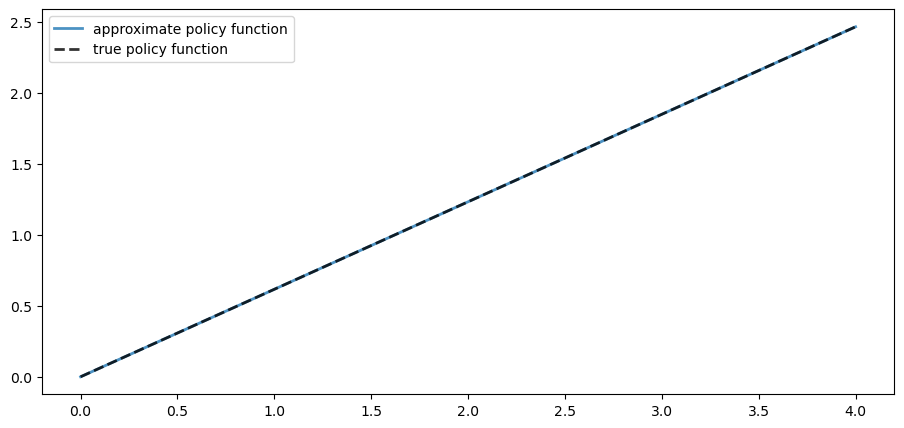

In [10]:
fig, ax = plt.subplots()

ax.plot(og.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(og.grid, σ_star(og.grid, og.α, og.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

Again, the fit is excellent.

The maximal absolute deviation between the two policies is

In [11]:
np.max(np.abs(σ - σ_star(og.grid, og.α, og.β)))

2.5329106132954138e-05

How long does it take to converge?

In [12]:
%%timeit -n 3 -r 1
σ = solve_model_time_iter(og, σ_init, verbose=False)

199 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


Convergence is very fast, even compared to our {doc}`JIT-compiled value function iteration <optgrowth_fast>`.

Overall, we find that time iteration provides a very high degree of efficiency
and accuracy, at least for this model.

## Exercises

```{exercise}
:label: cpi_ex1

Solve the model with CRRA utility

$$
u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$

Set `γ = 1.5`.

Compute and plot the optimal policy.
```

```{solution-start} cpi_ex1
:class: dropdown
```

We use the class `OptimalGrowthModel_CRRA` from our {doc}`VFI lecture <optgrowth_fast>`.

In [13]:
from numba import float64
from numba.experimental import jitclass

opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('γ', float64),          # Preference parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel_CRRA:

    def __init__(self,
                α=0.4,
                β=0.96,
                μ=0,
                s=0.1,
                γ=1.5,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.γ, self.μ, self.s = α, β, γ, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))


    def f(self, k):
        "The production function."
        return k**self.α

    def u(self, c):
        "The utility function."
        return c**(1 - self.γ) / (1 - self.γ)

    def f_prime(self, k):
        "Derivative of f."
        return self.α * (k**(self.α - 1))

    def u_prime(self, c):
        "Derivative of u."
        return c**(-self.γ)

    def u_prime_inv(c):
        return c**(-1 / self.γ)


Let's create an instance:

In [14]:
og_crra = OptimalGrowthModel_CRRA()

Now we solve and plot the policy:


Converged in 13 iterations.


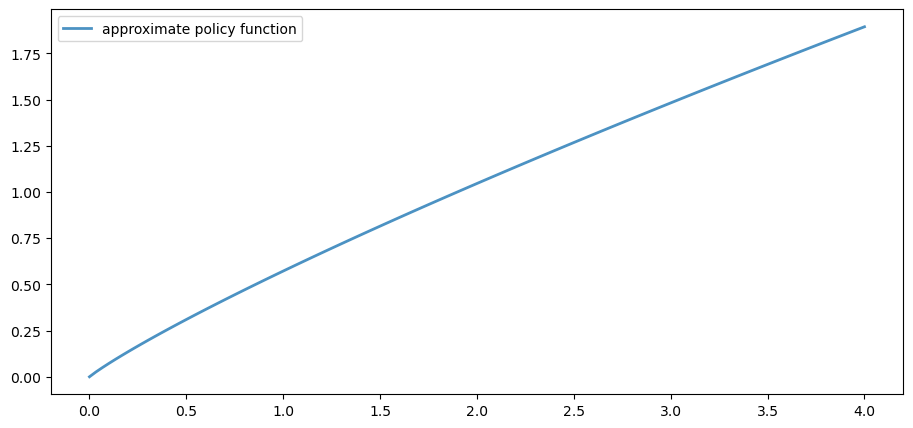

CPU times: user 2.16 s, sys: 67.5 ms, total: 2.23 s
Wall time: 2.23 s


In [15]:
%%time
σ = solve_model_time_iter(og_crra, σ_init)


fig, ax = plt.subplots()

ax.plot(og.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.legend()
plt.show()

```{solution-end}
```